# Secrets inside Clinton's email

## Abstract
In 2015, Hillary Clinton has been embroiled in controversy over the use of personal email accounts on non-government servers during her time as the United States Secretary of State. Over 2000 confidential emails were leaked, some of them are even classified as “Top Secret”. 

In this project we will look at the politic, security and economic aspects through the 7945 leaked emails redacted and published by the State Department and cleaned by Kaggle. We also want to analyze the personal social network of Hillary Clinton and the top topics they discussed.

As a superpower, the United States has a great impact on the world’s stability, and their position and attitude will strongly influence the international affairs. We want to figure out the countries mainly mentioned, the problems concerned and conclude the impact they made on the international affairs throughout the analysis of these emails.

The dataset can be found on [Kaggle](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Guideline: features discussed
* [Data wrangling](#data_wrangling): clean and deal with unvalid or missing data
* [Combine and merge data files](#combine_files) for further analysis: convert alias to PersonId
* Find the communication frequency between Hillary and the others in both direction: [From](#communication_From) and [To](#communication_To) Hillary
* Construct a [countries occurence list](#country_occ) and [visualization](#map_vis)
* Find [topics](#topic) discussed in the emails

---

<a id='data_wrangling'></a>
## Data wrangling: Clean and deal with unuseful data

In [2]:
import numpy as np
import pandas as pd
import math
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

import os
import json
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster
import branca
import warnings
from ipywidgets import interact
from datetime import datetime, timedelta

import nltk
from nltk.corpus import stopwords, opinion_lexicon
from nltk.tokenize import RegexpTokenizer
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
import wordcloud

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
warnings.simplefilter(action='ignore', category=FutureWarning)  # ignore future warnings

%matplotlib inline

In [3]:
data_folder    =  './hillary-clinton-emails/'
additional_data_folder = './additional-data/'

In [4]:
# load data and parse time to timestamp
emails_raw = pd.read_csv(data_folder + 'Emails.csv', parse_dates=['MetadataDateSent', 'MetadataDateReleased', 'ExtractedDateSent', 'ExtractedDateReleased'])

# load countries' boundaries and occurance of each country
geo_json_data  =  json.load(open(additional_data_folder + 'worldmap.geo.json'))

# load coordinate of each country
coord_contri   =  pd.read_excel(additional_data_folder + 'countries_codes_and_coordinates.xlsx')

# create world map and mideast map
world_map      =  folium.Map([46,17], tiles='cartodbpositron', zoom_start=2)
MidEast_map    =  folium.Map([33,58], tiles='cartodbpositron', zoom_start=4)

We extract information from the raw data in the following way:  
  
- **Release information**: some features in the data, for example `DocNumber`, are not of our concern. They are information of the release of the emails but not the information that the email itself tells. For this reason, we extract only useful features from the raw data.  
- **Redundant information**: there are also some features with a lot of `Nan` values, for example `ExtractedTo`. This overlaps with some information in `MetadataTo` and is not useful for our analysis, so we do not consider them. The `SenderPersonId` is a personId-parsed version of `MetadataTo`, so we also ignore this column.
- **Uncompleted data**: we have compare the `RawText` and `ExtractedBodyText`, and we deduce that the later is uncomplete. For textual information extraction we will only consider the first one.
- **Large data**: we extract the `RawText` from the raw data apart from the dataset because it is very large comparing to the other features. We will use this feature to mesure the textual information containing in the email, for example the countries mentioned ot other key words.

In [5]:
# extract useful information only
emails = emails_raw[['Id', 
                    'MetadataSubject',
                    'MetadataTo',
                    'SenderPersonId',
                    'MetadataDateSent',
                    'ExtractedReleaseInPartOrFull']]

# extract raw text for texual analysis
rawtext = emails_raw[['Id', 'RawText']]

In [6]:
# show emails
emails[:5]

,Id,MetadataSubject,MetadataTo,SenderPersonId,MetadataDateSent,ExtractedReleaseInPartOrFull
0,1,WOW,H,87.0,2012-09-12 04:00:00,RELEASE IN FULL
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,2011-03-03 05:00:00,RELEASE IN PART
2,3,CHRIS STEVENS,;H,32.0,2012-09-12 04:00:00,RELEASE IN PART
3,4,CAIRO CONDEMNATION - FINAL,H,32.0,2012-09-12 04:00:00,RELEASE IN PART
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",80.0,2011-03-11 05:00:00,RELEASE IN PART


In [7]:
emails.ExtractedReleaseInPartOrFull.unique()

array(['RELEASE IN FULL', 'RELEASE IN PART', 'UNKNOWN'], dtype=object)

We observe that `ExtractedReleaseInPartOfFull` seems to be categorical, so we decide to assign integer values to it.

In [8]:
str_vals = emails.ExtractedReleaseInPartOrFull.unique()
def part2int (x):
    if x == str_vals[0]:
        return 1
    elif x == str_vals[1]:
        return 0
    else:
        return -1

In [9]:
# attribute integer values for ExtractedReleaseInPartOrFull
emails.ExtractedReleaseInPartOrFull = emails.ExtractedReleaseInPartOrFull.apply(part2int)
emails = emails.rename(columns={'ExtractedReleaseInPartOrFull': 'is_Full'})
emails[:5]

,Id,MetadataSubject,MetadataTo,SenderPersonId,MetadataDateSent,is_Full
0,1,WOW,H,87.0,2012-09-12 04:00:00,1
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,2011-03-03 05:00:00,0
2,3,CHRIS STEVENS,;H,32.0,2012-09-12 04:00:00,0
3,4,CAIRO CONDEMNATION - FINAL,H,32.0,2012-09-12 04:00:00,0
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",80.0,2011-03-11 05:00:00,0


---

<a id='combine_files'></a>
## Combine and merge data files: convert involved alias to PersonId
Information on sender and receiver in the `Emails.csv` is aliases. One person can have multiple alias, so it is not easy for us to make further analysis. We thus convert all involved aliases to the personId by using `Aliases.csv`.

In [10]:
# Load data of alias
alias = pd.read_csv(data_folder + 'Aliases.csv')

In [11]:
# rearrange strings to a basic form
def manage_str(s):
    s = re.sub(r'\<.*', '', s)
    s = re.sub(r'\(.*\)', '', s)
    return s.lower()\
            .replace(',', '').replace('-', '').replace(' ', '').replace("'", '').replace('‘', '')\
            .replace('`', '').replace('°', '').replace('"', '').replace('•', '').replace('(', '')\
            .replace(')', '')

In [12]:
# create a dictionary of alias and personId
dict_alias = dict(zip(alias.Alias.apply(manage_str), alias.PersonId))

In [13]:
# convert alias to personId
def alias2id(alias):
    aliases = str(alias).split(';')
    ids = []
    for x in aliases:
        x = manage_str(x)
        if x in dict_alias.keys():
            ids.append(dict_alias[x])
    return ids

In [14]:
# Convert from alias to personId for five features related to people
emails.MetadataTo = emails.MetadataTo.apply(alias2id)

In [15]:
# rename columns in a more intuitive way and show the processed data
emails = emails.rename(columns={'MetadataSubject':'Subject', 
                                'SenderPersonId':'From', 
                                'MetadataTo':'To', 
                                'MetadataDateSent':'Date'})
emails[:5]

,Id,Subject,To,From,Date,is_Full
0,1,WOW,[80],87.0,2012-09-12 04:00:00,1
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[80],NaN,2011-03-03 05:00:00,0
2,3,CHRIS STEVENS,[80],32.0,2012-09-12 04:00:00,0
3,4,CAIRO CONDEMNATION - FINAL,[80],32.0,2012-09-12 04:00:00,0
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[81],80.0,2011-03-11 05:00:00,0


---

<a id='communication_From'></a>
## Find the communication frequency FROM and TO Hillary

### 1. Distribution of receivers of emails when the sender is Hillary

In [16]:
# load data of persons
persons = pd.read_csv(data_folder + 'Persons.csv')

In [17]:
# show data
persons[:5]

,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan
2,3,AP
3,4,ASUNCION
4,5,Alec


In [18]:
# dictionary that help searching for name of the person from its personId
dict_persons = dict(zip(persons.Id, persons.Name))

In [19]:
dict_persons[80]

'Hillary Clinton'

We observed from data that there are a lot of 80 values in the `To` and `From` column, and we verified that it is indeed Hillary Clinton - our petagonist.

In [20]:
# emails from Hillary to somebody
emails_H2sb = emails.loc[emails['From'] == 80]

In [21]:
# find all receivers
email_receivers = []
for i in emails_H2sb.To:
    for j in i:
        email_receivers.append(j)

In [22]:
# count for occurency
dict_receiver_count = dict(Counter(email_receivers))

In [23]:
# construct a dataframe for receiver and occurence
receiver_Ids = [ k for k in dict_receiver_count ]
receiver_occurences = [ v for v in dict_receiver_count.values() ]
receiver_count = pd.DataFrame({'receiver': receiver_Ids, 'occurence': receiver_occurences})

# sort by occurence and take the most important receivers
receiver_count = receiver_count.sort_values('occurence', ascending=False)
important_receiver = receiver_count[:15]

In [24]:
# convert receiver ids to names
names = []
for i in important_receiver.receiver:
    names.append(dict_persons[i])

important_receiver['name'] = names
important_receiver = important_receiver[['name', 'occurence']] # only keep information we need
important_receiver

,name,occurence
5,Cheryl Mills,354
4,a bed in h@state.gov,350
2,sulliva njj@state.g ov,297
7,Lauren Jiloty,234
8,Lona Valmoro,141
13,p rei n es,51
38,Sidney Blumenthal,50
0,Huma Abedin,37
6,ha nleym r@state.gov,33
64,Richard Verma,30


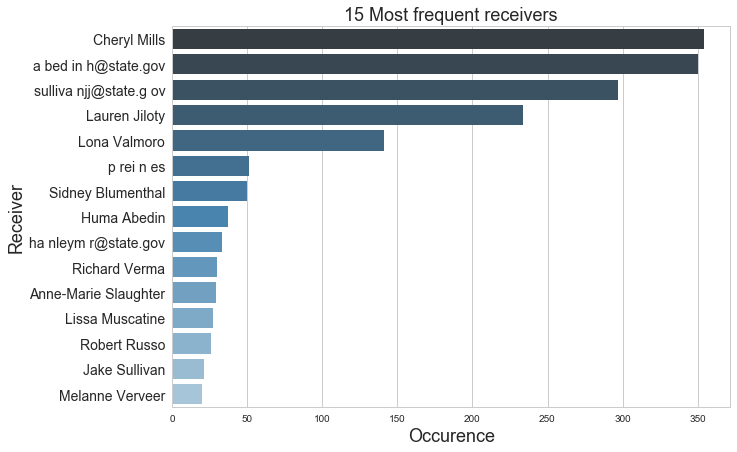

In [27]:
# plot a barplot of the most frequent receivers 
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})
ax = sns.barplot(data = important_receiver, y="name", x="occurence", palette="Blues_d")
ax.set_title('15 Most frequent receivers', size=18)
ax.set_yticklabels(important_receiver.name, size = 14)
ax.set_xlabel('Occurence', size = 18)
ax.set_ylabel('Receiver', size = 18);
plt.savefig('nw-freq-rec.png')

Some names don't seem to be clean data. We will analyze these people afterwards.

<a id='communication_To'></a>
### 2. Distribution of sender of emails when the receiver is Hillary

In [28]:
emails[:5]

,Id,Subject,To,From,Date,is_Full
0,1,WOW,[80],87.0,2012-09-12 04:00:00,1
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[80],NaN,2011-03-03 05:00:00,0
2,3,CHRIS STEVENS,[80],32.0,2012-09-12 04:00:00,0
3,4,CAIRO CONDEMNATION - FINAL,[80],32.0,2012-09-12 04:00:00,0
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,[81],80.0,2011-03-11 05:00:00,0


We want to verify whether we can parse a list of receivers to a single receiver. We can do this only if the list always contains 0 or 1 receiver.

In [29]:
# search for multi-receiver emails
multiple_receivers = []
for i in emails['To']:
    if len(i)>1:
        multiple_receivers.append(len(i))
multiple_receivers

[2, 2, 2, 2, 2, 2, 2, 2, 2]

So we cannot :(

In [30]:
# emails from somebody to Hillary
emails_sb2H_index = []
for index, email in emails.iterrows():
    if 80 in email.To:
        emails_sb2H_index.append(True)
    else:
        emails_sb2H_index.append(False)

emails_sb2H = emails[emails_sb2H_index]

In [31]:
# find all senders
email_senders = emails_sb2H.From.dropna()

In [32]:
# count for occurency
dict_sender_count = dict(Counter(email_senders))

In [33]:
# construct a dataframe for sender and occurence
sender_Ids = [ k for k in dict_sender_count ]
sender_occurences = [ v for v in dict_sender_count.values() ]
sender_count = pd.DataFrame({'sender': sender_Ids, 'occurence': sender_occurences})

# sort by occurence and take the most important senders
sender_count = sender_count.sort_values('occurence', ascending=False)
important_sender = sender_count[:15]

In [34]:
# convert sender ids to names
names = []
for i in important_sender.sender:
    names.append(dict_persons[i])

important_sender['name'] = names
important_sender = important_sender[['name', 'occurence']] # only keep information we need
important_sender

,name,occurence
7,Huma Abedin,1370
1,Cheryl Mills,1244
0,Jake Sullivan,840
5,Sidney Blumenthal,362
20,Lauren Jiloty,333
14,Philippe Reines,149
15,Lona Valmoro,141
2,Anne-Marie Slaughter,130
35,Richard Verma,117
12,Melanne Verveer,95


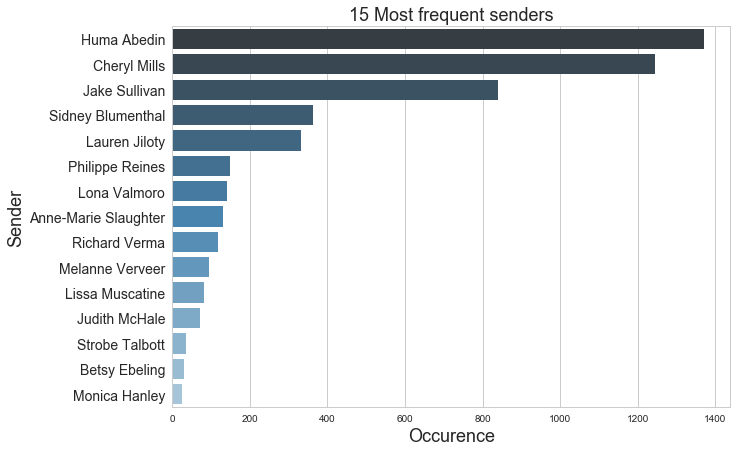

In [35]:
# plot a barplot of the most frequent senders 
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})
ax = sns.barplot(data = important_sender, y="name", x="occurence", palette="Blues_d")
ax.set_title('15 Most frequent senders', size=18)
ax.set_yticklabels(important_sender.name, size = 14)
ax.set_xlabel('Occurence', size = 18)
ax.set_ylabel('Sender', size = 18);
plt.savefig('nw-freq-send.png')

There are some people who are much closer to Hillary, again, we will analyze them later.  
  
An interesting observation: Huma Abedin, the person that receives the most emails FROM Hillary, is only the 8-th sender of emails TO Hillary. We guess that if she is Hillary's collegue, then she must excute more Hillary's order than make reports.

### 3. Information retrieved and further analysis

#### The anonymous senders: the relation between the anonymity and the `is_Full` value

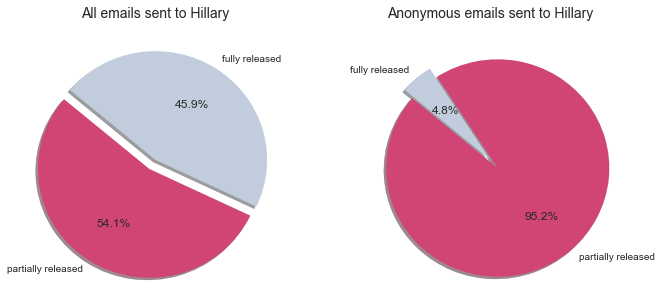

There are in total 5477 emails written to Hillary and among them there are 2961 partially released emails. 
There are also 20 of emails written to Hillay having an anonymous sender, and among the the anonymous emails, 19 are partially released.


In [93]:
# find all anonymous senders of Hillary's received emails
empty_senders = []
for index, row in emails_sb2H.iterrows():
    if math.isnan(row['From']):
        empty_senders.append((row['Id'], row['is_Full']))
        
# find all partial emails
emails_partial = emails_sb2H[emails_sb2H['is_Full'] == 0]

# anonymous emails having partial content
num_partial_anonymous = 0
for _, full in empty_senders:
    if full == 0:
        num_partial_anonymous +=1

        
num_sb2H = len(emails_sb2H)
num_part = len(emails_partial)
num_anon = len(empty_senders)
num_partial_anonymous

fig, ax = plt.subplots(ncols=2, figsize = (11,5))
# Data to plot
labels1 = 'partially released', 'fully released'
sizes1 = [num_part, num_sb2H - num_part]
labels2 = 'partially released', 'fully released'
sizes2 = [num_anon, num_anon - num_partial_anonymous]
colors = ['#d14576', '#c1ccdd']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.subplot(121)
plt.pie(sizes1, explode=explode, labels=labels1, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('All emails sent to Hillary', size=14)
 
plt.subplot(122)
plt.pie(sizes2, explode=explode, labels=labels2, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Anonymous emails sent to Hillary', size=14)

plt.show()

print(f'There are in total {len(emails_sb2H)} emails written to Hillary and among them there are {len(emails_partial)} partially released emails. \n\
There are also {len(empty_senders)} of emails written to Hillay having an anonymous sender, and among the the anonymous emails, {num_partial_anonymous} are partially released.')

We suppose that the anonymous emails sent to Hillary are possibly confidential, that the sender is erased by the State Department before release. Almost all of them are released partially.

#### The proportion of emails Hillary send and receive

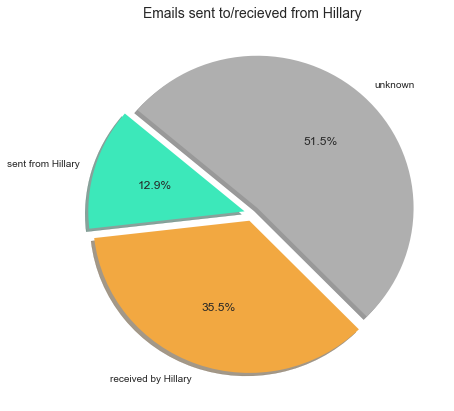

Among all emails released by the State Department, 
 25.08% are sent by Hillary Clinton and 68.94% are received by Hillary.


In [91]:
pct_sent = len(emails_H2sb) / len(emails)
pct_rec = len(emails_sb2H) / len(emails)
pct_unknown = (len(emails)-pct_sent-pct_rec)/len(emails)

# Data to plot
labels = 'sent from Hillary', 'received by Hillary', 'unknown'
sizes = [pct_sent, pct_rec, pct_unknown]
colors = ['#3ce8ba', '#f2a841', '#afafaf']
explode = (0.05, 0.05, 0.05)  # explode 1st slice
 
# Plot
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Emails sent to/recieved from Hillary', size=14)
plt.show()


print('Among all emails released by the State Department, \n \
{:.2%} are sent by Hillary Clinton and {:.2%} are received by Hillary.'.format(pct_sent, pct_rec))

#### Important persons involved, their relation with Hillary or their political position

From the two graphs we plot for the `important_receiver` and the `important_sender`, we highlight the following people:  
_(Information from Wikipedia)_

In [35]:
important_receiver

,name,occurence
5,Cheryl Mills,354
4,a bed in h@state.gov,350
2,sulliva njj@state.g ov,297
7,Lauren Jiloty,234
8,Lona Valmoro,141
13,p rei n es,51
38,Sidney Blumenthal,50
0,Huma Abedin,37
6,ha nleym r@state.gov,33
64,Richard Verma,30


<img src="network.png", style="width: 800px;">

**Huma Abedin** : the most frequent sender and the 8-th most frequent receiver.
>- _**Vice chair of Hillary Clinton's 2016 campaign** for President of the United States._
- _**Deputy chief of staff to Clinton**, who was U.S. Secretary of State from 2009 to 2013._
- _**Traveling chief of staff and former assistant for Clinton** during Clinton's campaign for the Democratic nomination in the 2008 presidential election._ 

She is clearly the right-hand woman of Hillary Clinton.

**Cheryl Mills** : the 2nd most frequent sender and the most frequent receiver
> - _**Counselor and Chief of Staff to Hillary Clinton** during her whole tenure as United States Secretary of State_.
- _**Senior Adviser and Counsel for Hillary Clinton's 2008 presidential campaign**, and is considered a member of Hillary Clinton's group of **core advisers**, self-designated as "Hillaryland"._
- _**Deputy White House Counsel for President Bill Clinton**, whom she defended during his 1999 impeachment trial._

Another right-hand woman of Hillary Clinton. From the last point we can also see that she is loyal to the Clinton family.

**Jacob Jeremiah Sullivan (Jake Sullivan)** : the 3rd most frequent sender and the 14-th most frequent receiver.
>- _American policymaker, **senior policy advisor to Hillary Clinton**'s 2016 U.S. presidential election campaign, with expertise in foreign policy._
- _**Deputy Chief of Staff to U.S. Secretary of State Hillary Clinton**._ 
- _**Deputy policy director on Hillary Clinton**'s 2008 presidential primary campaign._

**Sidney Blumenthal** : the 4-th most frequent sender and the 7-th most frequent receiver.
>- _**Journalist, activist**, writer, and political aide._
- _Former aide to President Bill Clinton._
- _A long-time **confidant of Hillary Clinton**._
- _Formerly employed by the **Clinton Foundation**._

**Philippe I. Reines**: the 6-th most frequent sender and the 6-th most frequent receiver.
> - _**Senior Advisor to Hillary Clinton** when she became United States Secretary of State in January 2009._
- _Deputy Assistant Secretary of State for Strategic Communications, 2010._

These are people with whom Hillary communicate most frequently, and they are clearly politicians, collegues of Hillary Clinton. We conclude that she definitely use her personal email accounts on non-government servers and send professional emails to her collegues during her time as the United States Secretary of State, which is horrible for the national security.  
  
According to the FBI examination, _"over 100 emails containing classified information, including 65 emails deemed "Secret" and 22 deemed "Top Secret", none with classification markings. An additional 2,093 emails not marked classified were retroactively classified by the State Department."(wikipedia)_. It is almost unimaginable how come a politician at her position can be that inprudent.

---

<a id='country_occ'></a>
## Construct a countries occurence list

In order to construct a countries occurence list, we need a dataset of all country names. Here we use a dataset from [Statgraphics](http://www.statgraphics.com/).

In [36]:
additona_data_folder = './additional-data/'

# load the country dataset
country_dataset_raw = pd.read_excel(additona_data_folder + 'countries of the world.xls')

In [37]:
# data wrangling on the country dataset
country_dataset = country_dataset_raw['Data is public domain from US government.'].drop([0,1,2,3], axis = 0)

# remove space at the and of each country
country_dataset = country_dataset.apply(lambda x : x[:-1])

In [38]:
# raw text values
rawtext_list = rawtext['RawText']

People usually call some countries by their abbreviations. For example, we often say "UK" instead of "United Kingdom". For this reason, we also add abbreviations for some countries.

In [39]:
# add other wildly-used names for some of the countries
add_countries = pd.Series(['North Korea', 'DPRK', 'South Korea', 'RDK', 'Korea','UK'])
country_dataset = country_dataset.append(add_countries)

In [40]:
# lower the letters in rawtext and country name
rawtext_lower = rawtext_list.str.lower()   
country_dataset_lower = country_dataset.str.lower()
country_occurences = []

# calculate the occurence
for i in range(country_dataset.shape[0]):
    country_lower = country_dataset_lower.iloc[i]
    country = country_dataset.iloc[i]
    occurence_result = rawtext_lower.str.contains(country_lower).replace([False, True], [0, 1])
    occ_sum = occurence_result.sum()
    country_occurences.append((country, occ_sum))
    
    if occ_sum > 0:
        rawtext[country] = pd.DataFrame(occurence_result)

In [41]:
# match the EmailId and the occurence number
id_occurence = rawtext.drop(['RawText'], axis = 1)

Here we merge the occurence of abbreviations with the the original name. When we say "Korea", we usually mean "South Korea". So we compute the occurence of South Korea by substracting the occurence of Korea by the occurence of North Korea.

In [42]:
id_occurence['United Kingdom'] = (id_occurence['United Kingdom'] + id_occurence['UK']).replace(2,1)
id_occurence['South Korea'] = id_occurence['Korea'] - id_occurence['North Korea']
id_occurence['North Korea'] = (id_occurence['North Korea'] + id_occurence['DPRK']).replace(2,1)

id_occurence = id_occurence.drop(['UK', 'DPRK', 'Korea'], axis=1)

In [43]:
# prepare data for plot
occurences_plt = id_occurence.drop(['Id'], axis=1).sum(axis = 0)
occurences_plt = occurences_plt.sort_values(ascending=False)
occurences_plt[:5] 

United States    736
Iran             453
Israel           447
Afghanistan      410
Haiti            403
dtype: int64

We want to figure out strategy focus of the US, so we won't show the occurence of US in the plot. It is not surprising that it is the most frequently mentioned country in Hillary's emails.

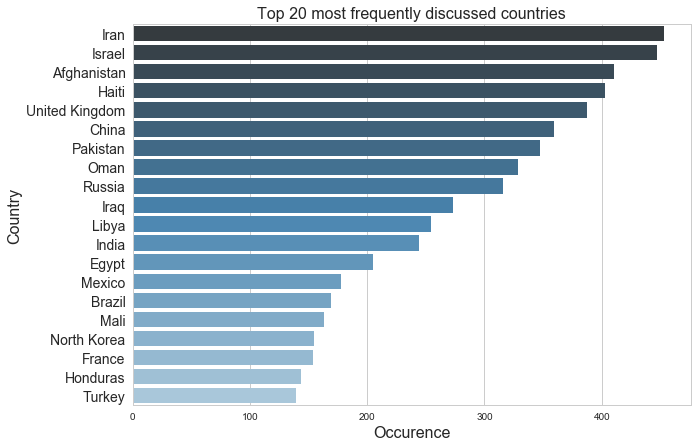

In [44]:
# plot the country occurence
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})

occurences_plt = occurences_plt[1:21]
ax = sns.barplot(x = occurences_plt.values, y=occurences_plt.index, palette="Blues_d")
ax.set_title('Top 20 most frequently discussed countries', size=16)
ax.set_yticklabels(occurences_plt.index, size = 14)
ax.set_xlabel('Occurence', size = 16)
ax.set_ylabel('Country', size = 16);

We observe that the most focused countries are in the middle east. To haa

***

<a id='map_vis'></a>
## Create the Occurrence-World-Map

To visualize the occurrence of each country or region in Hillary's emails, we create a Occurrence World Map. This map allocates a certain color, from light orange to dark red, to each country/region with respect to the frequency of occurrence of the country/region. The darker a country/region is, the higher frequency of occurrence the country has.

The geojson data generated from [geojson-maps](https://geojson-maps.ash.ms/).

In [45]:
# drop data that are irrelevant to our analysis
country_list   = id_occurence
country_list   = country_list.drop(['United States'], axis = 1)
country_list   = country_list.rename(columns={'South Korea': 'Korea', 'North Korea':'Dem. Rep. Korea'} )
country_count  = pd.DataFrame( {'countries': country_list.columns.values[1:], 'counts':country_list.sum()[1:]} )
country_count  = country_count.reset_index(drop=True)

# align countries's name in the dataframe that contains coordinates and countries
coord_contri.set_value( coord_contri.loc[coord_contri.name == "North Korea"].index, 'name', 'Dem. Rep. Korea')
coord_contri.set_value( coord_contri.loc[coord_contri.name == "South Korea"].index, 'name', 'Korea')

# create a color map
colorscale = branca.colormap.linear.OrRd_09.scale( 0, country_count.counts.max() )

In [46]:
# define a style_function to specify the appearance of our map
def counts_colors(country, counts_data):
    """Maps counts to different color."""
    try:  
        # if the the country (in the geo json file) is contained in the counts_data dataframe, get its frequency (counts)
        freq = counts_data.loc[counts_data['countries'] == country, 'counts'].values[0]
    except:
        # the country is not in the dataframe, set its value to np.nan
        freq = np.nan
        
    if np.isnan(freq):
        # for country not in the dataframe, map it to white
        return '#4D5656'
    else:
        # for country in the dataframe, map it to its cooresponding color
        return colorscale(freq)

In [47]:
# add geo data to the map, with different colors representing different frequencies ( orange -> red <=> low freq -> high freq )
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': counts_colors(feature['properties']['name'], country_count),
        'fillOpacity': 0.8,
        'weight': 0
        }
    ).add_to(world_map)

world_map

You can click [here](map_borders.html) to see the map.

Viewing from the occurrence world map, it is obvious that asian countries and middle east countries are the most frequently mentioned countries in Hillary's emails. There are also some european countries and central america countries often appear in the emails, such as the United Kingdom and Haiti. To see it more clear, we zoom in to the middle east as below.

In [48]:
# focus on middle east countries
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': counts_colors(feature['properties']['name'], country_count),
        'fillOpacity': 0.8,
        'weight': 0
        }
    ).add_to(MidEast_map)
MidEast_map

You can click [here](MidEast_map.html) to see the map.

Middle east countries like Pakistan, Afghanistan, Oman, Iran, Iraq and Israel are the top 6 countries mentioned in the emails.

We can make further analysis:
1. obtian the timestamp of occurrence of each country;
2. visualize the time series using an interactive map;
3. after abtaining the attitute of Hillary toward each country, generate an attitute map; 
4. analyze the results.

In [49]:
# extract contries mentioned more than 100 times
top_countries_Sr = country_count.loc[country_count.counts>=100].countries

# extract emails and their date
email_time_df    = emails[['Id', 'Date']]

In [50]:
'''
for each frequenctly mentioned country, we process it as follow:
 step 1. find the email that metioned this country
 step 2. merge the email list with the email_time datafrme by Id to obtain the date that the country was mentioned, then drop unvalid NaT
 step 3. for each date, pich only the year and month
 step 4. group the dataframe by the date

Finally, we obtain a list of dataframe, each dataframe contains all occurence date of a country
'''

for ct in range(0, top_countries_Sr.shape[0]):
    # step 1
    ConTri_name      = top_countries_Sr.iloc[ct]
    id_ConTri_df     = country_list[['Id',ConTri_name]]
    email_ConTri_df  = id_ConTri_df.loc[id_ConTri_df[ConTri_name]>=1]
    
    # step 2
    time_ConTri_df   = email_ConTri_df.merge(email_time_df, on = 'Id').dropna()

    # step 3
    time_ConTri_df['Date'] = time_ConTri_df.Date.apply(lambda r: r.strftime("%y/%m"))
    
    # step 4
    if ct == 0:
        month_ConTri = time_ConTri_df.groupby('Date').count().reset_index()[['Date', ConTri_name]].sort_values('Date')
    else:
        temp = time_ConTri_df.groupby('Date').count().reset_index()[['Date', ConTri_name]].sort_values('Date')
        month_ConTri = month_ConTri.merge(temp, on='Date', how='outer')

In [51]:
def monthly_plot( month_th = 5 ):           
        
    counts_data_Sr = country_data.iloc[month_th].dropna()
    counts_data    = pd.DataFrame({'countries': counts_data_Sr.index[1:], 'counts':counts_data_Sr.values[1:]})
    
    folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': counts_colors(feature['properties']['name'], counts_data),
        'fillOpacity': 0.8,
        'weight': 0
        }
    ).add_to(world_map)
    
    world_map.save('world_map' + str(month_th) + '.html')

In [52]:
counts_data = pd.DataFrame()
counts_data
    
folium.GeoJson(
geo_json_data,
style_function=lambda feature: {
    'fillColor': counts_colors(feature['properties']['name'], counts_data),
    'fillOpacity': 0.8,
    'weight': 0
    }
).add_to(world_map)

world_map.save('world_map_nan' + '.html')

In [53]:
country_data = month_ConTri 
max_counts = max(month_ConTri.max()[1:])
colorscale = branca.colormap.linear.OrRd_09.scale( 0, month_ConTri.max()[1:].sort_values()[-2] )

interact(monthly_plot, month_th=range(0, month_ConTri.shape[0]));

interactive(children=(Dropdown(description='month_th', index=5, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,…

In [54]:
country_data.columns

Index(['Date', 'Afghanistan', 'Brazil', 'China', 'Egypt', 'France', 'Germany',
       'Haiti', 'Honduras', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland',
       'Israel', 'Japan', 'Libya', 'Mali', 'Mexico', 'Oman', 'Pakistan',
       'Russia', 'Sudan', 'Turkey', 'United Kingdom', 'Dem. Rep. Korea'],
      dtype='object')

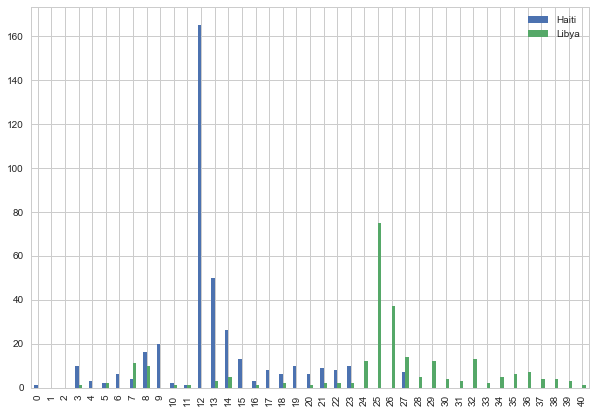

In [55]:
country_data[['Date', 'Haiti', 'Libya']].plot.bar();

---

## Sentiment Analysis

Hillary was the secretary of state and responsible for diplomacy of US in the period from 2008 to 2013. Therefore, from her emails, we can find out the attitude of US in diplomatic relations with other countries.

In this part, we implement [VADER Lexicon](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf), which is a simple rule-based model for general sentiment analysis, to analyze the sentiment in Hilary's emails. This lexicon is widely used in social media text sentiment analysis and performs efficiently. 

In [56]:
text = emails_raw['RawText']

In [57]:
# calculate the sentiment score of each email
sia = SentimentIntensityAnalyzer()
sentiment_score = np.zeros(text.shape[0])
for i in range(text.shape[0]): 
    scores = sia.polarity_scores(text[i])
    sentiment_score[i] = scores['compound']

In [58]:
# attach the sentiment score to each email id
emails['Sentiment Score'] = sentiment_score

In [59]:
# combine the country occurence and sentiment score in each email
id_sentiment = id_occurence
for i in range(id_occurence.shape[0]):
    if id_occurence.iloc[i].sum() > 0:
        id_sentiment.iloc[i] = id_occurence.iloc[i].replace(1 ,sentiment_score[i])

#### Analysis for countries with which the emails have positive sentiments

In [60]:
# prepare data to plot the positive sentiment group
sentiment_plt = id_sentiment.drop(['Id'], axis=1).sum(axis = 0)
pos_sentiment_plt = sentiment_plt.sort_values(ascending=False)
pos_sentiment_plt[:5]

United States    128.8430
China             59.0485
India             43.1020
Oman              38.2183
Haiti             36.5851
dtype: float64

We want to figure out the sentiment of the US to other countries or regions, so we won't show the sentiment score of US in the plot. It is not surprising that US has the most positive sentiment in Hillary's emails.

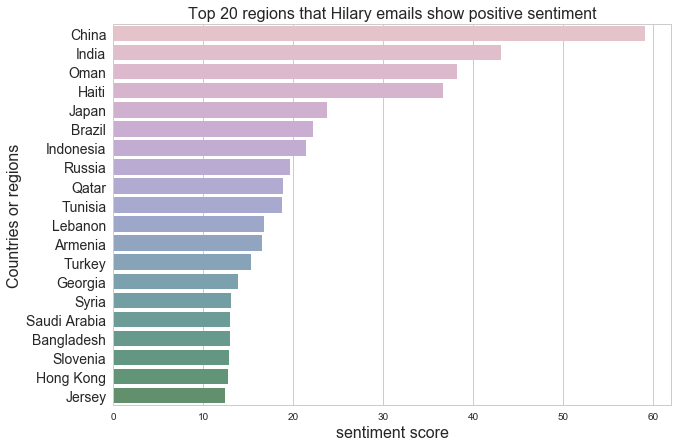

In [61]:
# plot the positive sentiment countries
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})

pos_plt = pos_sentiment_plt[1:21]
ax = sns.barplot(x = pos_plt.values, y = pos_plt.index, 
                 palette=sns.cubehelix_palette(20, start=2, dark=0.5, light=0.8, rot=2))
ax.set_title('Top 20 regions that Hilary emails show positive sentiment', size=16)
ax.set_yticklabels(pos_plt.index, size = 14)
ax.set_xlabel('sentiment score', size = 16)
ax.set_ylabel('Countries or regions', size = 16);

The Hilary's emails are within the period from 2008 to 2013, so we will associate US's policy and international events to the sentiments of Hilary's emails. We highlight some countries and regions here:

**China**:
  Obama was friendly with China during his presidency, and as a result, the bilateral relationship between China and US, two superpower in the world, maintains more or less stable in this period. For example, at the end of 2014, the US government carried out for the first time a 10-year visa policy to promote communication between the two countries. Meanwhile, after the 2008 international financial crisis, US was strongly influenced and wanted to recover it by strengthening cooperation in economics with China.
  
**India**:
India, as the largest democracy country in population, has always maintained a closed bilateral relations with US and has widely communication and cooperation in economics and technology with US.

**Oman**:
Oman is a Middle East country with abundant oil reserve and the fortress country of the Strait of Hormuz, which attracts the attention of US government. And US and Oman launched negotiations on a Free Trade Agreement that were successfully concluded in October 2005. So the bilateral relation is positive and stable.   

**Haiti**:
Haiti suffered a serious earthquake in January 2010. President Obama announced a 100m$ US aid package to help Haiti. We think that the emails mentioning Haiti are about supporting Haiti.

**Russia**:
The Crimean Crisis happened in 2014, and the tension was only after the crisis. Before the crisis Russia and US had kept cooperation.

**Japan, Brasil, Hongkong, ... :**
Those are countries or region which are important economies and have no big conflit with US. So we think that emails mentioning these countries talk especially about cooperation.

**Qatar, Turkey, ... :**
These Middle-east countries had no economic or political conflit with US at that period and US do need cooperation with countries with abundant oil reserve and alliance countries in the Middle-east area.


  
After analysis about the bilateral relations with some typical countries or region, we find that the positive sentiment countries have the following properties:
- Long-term friendly country by historical reasons
- Important fortress country in channel or other transportation line
- Country with abundant oil reserve
- Economically cooperative country without conflict of interest

#### Analysis for countries with which the emails have negative sentiments

In [62]:
# prepare data to plot the negative sentiment group
neg_sentiment_plt = sentiment_plt.sort_values(ascending=True)

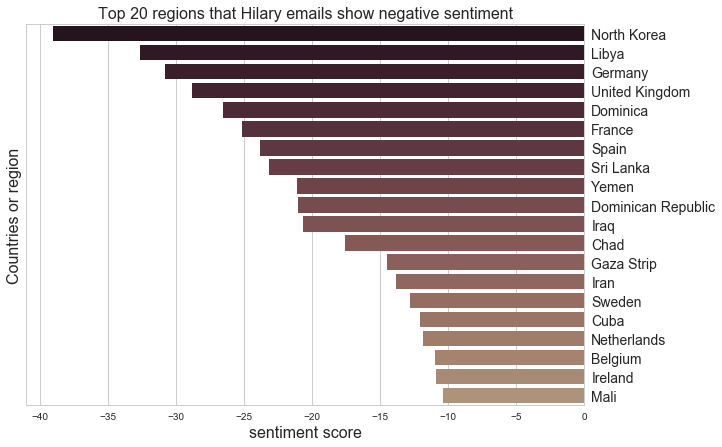

In [63]:
# plot the negative sentiment countries
sns.set(style="whitegrid", rc={'figure.figsize':(10, 7)})

neg_sentiment_plt = neg_sentiment_plt[:20]
ax = sns.barplot(x = neg_sentiment_plt.values, y = neg_sentiment_plt.index, 
                 palette=sns.cubehelix_palette(20, start=.5, light=0.6, dark=0.1, reverse=True))
ax.set_title('Top 20 regions that Hilary emails show negative sentiment', size=16)
ax.set_yticklabels(neg_sentiment_plt.index, size = 14)

# # Text on the top of each barplot
# for i in range(len(neg_sentiment_plt.index)):
#     ax.text(x = neg_sentiment_plt.values[i] - 1 - len(neg_sentiment_plt.index[i])*0.5,
#              y = i+0.2, 
#              s = neg_sentiment_plt.index[i], 
#              size = 14)

# ax.set_xlim(left= -50)
ax.yaxis.tick_right()
ax.set_xlabel('sentiment score', size = 16)
ax.set_ylabel('Countries or region', size = 16);

Same as for the positive sentiment countries, we highlight the following countries to analyze:

**North Korea**: North Korea conducted two nuclear explosion tests during this period, respectively in May 2009 for the first time ever in the history and February 2013 for the second time. The US government claimed that the test will affect international security and strongly opposed this kind of test. So sentiment in emails to North Korea is negative in this period of time. 

**Libya**: In 2012, when Benghazi, the base camp of the opposition force, is almost occupied by the Gaddafi government, the [Benghazi attack](https://en.wikipedia.org/wiki/2012_Benghazi_attack) took place and the US ambassador to Libya was killed, This caused a serious consequence: the United Nations Security Council passed a resolution and US, together with United Kingdom and France, bombed Libya by air force. Hillary, as the Secretary of State during this period, mostly took charge of US diplomacy, so her emails mentioning Libya must had been with negative sentiments, as it was a serious international incident.

**Germany, United Kingdom, France ... :** These are major countries in North Atlantic Treaty Organization (NATO) which participated the action to bomb Libya. The cooperation at this level certainly talked about negative subject as NATO is a military alliance.

After analysis about the bilateral relations with some typical countries, we find that countries with which Hillary had a negative sentiment all have one of the following properties:
- Country in NATO taking the same position with US
- Country with an unstable government or with an difficult political situation


In conclusion, Hillary, as the secretary of state, concentrates mainly on political issues. The countries that she shows a positive sentiment do not have political conflicts with US and the countries that she shows negative sentiment are either taking a opposite position of US, or military alliance countries of US.

---

<a id='topic'></a>
## Topics: key words

In [64]:
stopwords = set(stopwords.words('english'))

useless_words = ['one'  , 'could'  , 'many'  , 'also'  , 'years'  , 'well'  , 'would'  , 'us'   , 'time'   , 'two', 
                 'back' , 'today'  , 'even'  , 'said'  , 'last'   , 'see'   , 'since'  , 'like' , 'another', 'long',
                 'first', 'may'    , 'com'   , 'men'   , 'use'    , 'late'  , 'ever'   , 'home' , 'able'   , 'day',
                 'end'  , 'comm'   , 'mtg'   , 'making', 'think'  , 'travel', 'mentioned', 'thinking'      , 'plane',
                 'sure' , 'docx'   , 'turned', 'call'  , 'coming' , 'jack'  , 'toward' , 'million', 'man'  , 'possible',
                 'asked', 'send'   , 'got'   ,'percent', 'led'    , 'big'   , 'john'   , 'jim'    , 'mills', 'dtype']

In [65]:
texts = emails_raw[['Id', 'ExtractedBodyText']]

In [66]:
texts.ExtractedBodyText = texts.ExtractedBodyText.replace(np.nan, '', regex=True)

In [67]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

['Eighty', 'seven', 'miles', 'to', 'go', 'yet', 'Onward']

In [68]:
texts_mx = []
tokenizer = RegexpTokenizer(r'\w+')

for index, row in texts.iterrows():
    
    filtered_words = [] 
    words = tokenizer.tokenize(row['ExtractedBodyText'])

    for w in words: 
        if w.lower() not in stopwords and w.lower() not in useless_words: 
            filtered_words.append(w) 

    texts_mx.append([index, dict(Counter(filtered_words))])

In [69]:
words = []
for w in texts_mx:
    words.append(list(w[1]))

---

### TF-IDF

In [70]:
# create country list
# top 50 most frequently mentioned countries
country_list_BOW = country_count.sort_values('counts', ascending=False).countries[:50].values
country_list_BOW[country_list_BOW == 'Dem. Rep. Korea'] = 'North Korea'
document_list = [''] * country_list_BOW.shape[0]

# group all emails by countries mentioned in their body text -- used for tf-idf
for item in words:
    if len(item) == 0:
        continue
     
    index = 0
    combine_str = ' '.join(map(str, item))
    for country in country_list_BOW:
        if country.lower() in combine_str.lower():
            document_list[index] = document_list[index] + ' ' + combine_str
        index += 1

In [71]:
# obtain a keywords set

# 1. flatten the words list
flat_list = [item for sublist in words for item in sublist]

# 2. count unique words in the word list and build a dict: {key: words -> value: counts}
dict_words = dict(Counter(flat_list))
keys2drop = []

# drop the words: 1. mentioned less than 50 times 
#                 2. shorter than 3 
for k, v in dict_words.items():
    if v < 50 or len(k) < 3:
        keys2drop.append(k)

for k in keys2drop:
    dict_words.pop(k)
    
# pick keys and use their lowercase
words_set = dict_words.keys()
words_set = set([w.lower()for w in words_set])

In [72]:
# create TF (Term Frequency) matrix
tf_mat = np.zeros([len(document_list),len(words_set)])
ct = 0

for ind_word, word in enumerate(words_set):
    ct +=1
    if( round(ct/len(words_set)*100)%5 == 0):
        print('We have accomplished:', round(ct/len(words_set)*100), '% of the creation.', end='\r')
    for ind_doc, doc in enumerate(document_list):
        tf_mat[ind_doc, ind_word] = doc.lower().count(word.lower())
        
print('We have successfully created the TF matrix', end='\r')

tf_pd = pd.DataFrame(tf_mat, columns=words_set, index=country_list_BOW)

In [73]:
# create IDF(Inverse Document Frequency) vector
temp_pd = tf_pd.copy()
temp_pd[temp_pd > 0] = 1

idf_vec = np.zeros([tf_pd.shape[1], 1])
for ind_col, col_name in enumerate(temp_pd):
    idf_vec[ind_col] = temp_pd[col_name].sum()
    
idf_vec = np.log(tf_pd.shape[0]) - np.log(idf_vec)
idf_pd  = pd.DataFrame(idf_vec.T, columns=words_set)

In [74]:
# compute TF-IDF matrix
tf_idf = np.zeros(tf_pd.shape)

for ind_word, word in enumerate(idf_pd):
    tf_idf[:,ind_word] = tf_pd[word]*idf_pd[word].values

tfidf_df = pd.DataFrame(tf_idf, columns=words_set, index=country_list_BOW)
tfidf_df.reset_index(inplace = True)
tfidf_df.rename({'index': 'Countries'}, axis=1, inplace = True)

In [75]:
# standardize tfidf country by contry
for ind, val in tfidf_df.iterrows():
    _mean = tfidf_df.iloc[ind,1:].mean()
    _std  = tfidf_df.iloc[ind,1:].std()
    tfidf_df.iloc[ind,1:] = (tfidf_df.iloc[ind,1:] - _mean)/_std

In [76]:
# for first 10 country drop words that have low tf-idf values
for index, word in enumerate(tfidf_df.iloc[:10,1:]):
    if sum(abs(tfidf_df[word][:10]) >= 3) == 0:
        tfidf_df.drop(word, axis = 1, inplace = True)

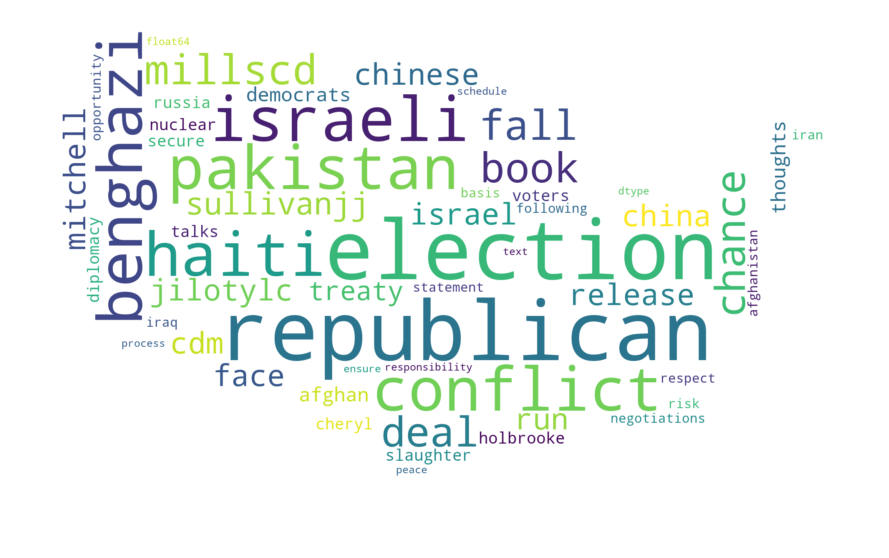

In [79]:
from PIL import Image
from os import path
import os
import random

from wordcloud import WordCloud
words_cloud = tfidf_df.iloc[:,1:].abs().sum(axis = 0).sort_values(ascending = False)

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image taken from
mask = np.array(Image.open(path.join(d, "AmericanBorder.png")))

wc = WordCloud(background_color='white', mask=mask, margin=10 ).generate(str(words_cloud))

# store default colored image
plt.figure(figsize=(15,10))
default_colors = wc.to_array()
plt.imshow(wc, interpolation="bilinear")
wc.to_file("a_new_hope.png")
plt.axis("off")
plt.show()

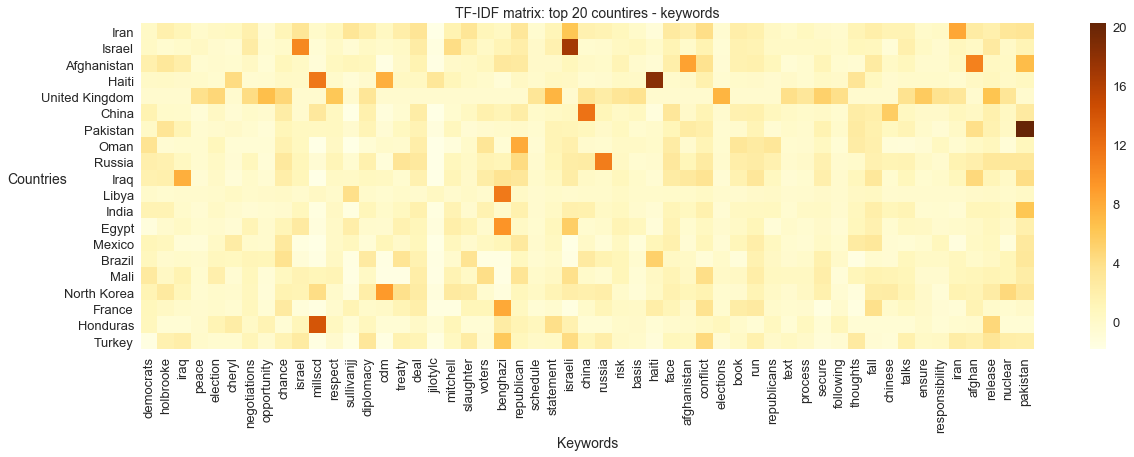

In [80]:
plt.figure( figsize=(20,6) )
sns.set(font_scale=1.3)
ax1 = sns.heatmap(tfidf_df.iloc[:20,1:], cmap="YlOrBr", 
                  vmin=tfidf_df.iloc[:20,1:].min().min(), 
                  vmax=tfidf_df.iloc[:20,1:].max().max(),
                  xticklabels=tfidf_df.columns[1:],
                  yticklabels=tfidf_df.Countries[:20])
plt.title('TF-IDF matrix: top 20 countires - keywords',fontsize=14)
plt.xlabel('Keywords',fontsize=14)
plt.ylabel('Countries',fontsize=14, rotation = 'horizontal')
plt.show()

***